# Preparing the Dataset

Unzipping the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
dataset_directory = '/content/drive/MyDrive/archive (2).zip'
zip_ref = zipfile.ZipFile(dataset_directory, 'r')
zip_ref.extractall('Cervical Cancer Dataset')
zip_ref.close()
# Takes about 6m 22s to unzip.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Formatting the directory and image file, and preparing the csv file

In [ ]:
# Importing Necessary Libraries
import cv2
import os
import shutil 
import math
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Dataset_source = '/content/Cervical Cancer Dataset'
#Dataset_dest = './CervicalCancer'
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]


Dyskeratotic = '/content/Cervical Cancer Dataset/im_Dyskeratotic/im_Dyskeratotic'
Koilocytotic = '/content/Cervical Cancer Dataset/im_Koilocytotic/im_Koilocytotic'
Mtaplastic = '/content/Cervical Cancer Dataset/im_Metaplastic/im_Metaplastic'
Parabasal = '/content/Cervical Cancer Dataset/im_Parabasal/im_Parabasal'
Superficial_Intermediate = '/content/Cervical Cancer Dataset/im_Superficial-Intermediate/im_Superficial-Intermediate'

subfolder_list = [Dyskeratotic, Koilocytotic, Mtaplastic, Parabasal, Superficial_Intermediate]

file_path = []
classification = []

cervical_cancer_df = pd.DataFrame()
for i in range(0,5):
  image = os.listdir(subfolder_list[i])
  for file in image:
    f1, f2 = os.path.splitext(file)
    if f2 == '.bmp':
      dst = file[:-3] + 'jpg'
      src =f"{subfolder_list[i]}/{file}"
      file = dst
      dst =f"{subfolder_list[i]}/{dst}"
      os.rename(src, dst)

      classification.append(classes[i])
      file_path.append(subfolder_list[i] + '/' + file)

path_df = pd.DataFrame(file_path, columns=['Path'])
class_df = pd.DataFrame(classification, columns=['Classification'])
class_id = pd.DataFrame(classification, columns=['Classification_ID'])

temp = pd.concat([path_df, class_df, class_id], axis = 1)
cervical_cancer_df = pd.concat([cervical_cancer_df, temp], axis = 0)



cervical_cancer_df.Classification_ID.replace({"Dyskeratotic": 0,"Koilocytotic": 1,"Metaplastic": 2,"Parabasal":3,"Superficial-Intermediate":4}, inplace=True)

In [ ]:
cervical_cancer_df.head()

,Path,Classification,Classification_ID
0,/content/Cervical Cancer Dataset/im_Dyskeratot...,Dyskeratotic,0
1,/content/Cervical Cancer Dataset/im_Dyskeratot...,Dyskeratotic,0
2,/content/Cervical Cancer Dataset/im_Dyskeratot...,Dyskeratotic,0
3,/content/Cervical Cancer Dataset/im_Dyskeratot...,Dyskeratotic,0
4,/content/Cervical Cancer Dataset/im_Dyskeratot...,Dyskeratotic,0


In [ ]:
cervical_cancer_df.shape
cervical_cancer_df.Classification.unique()
cervical_cancer_df.to_csv(r'cervical_cancer.csv', index=False) # to save the csv file in the vm directory
len(cervical_cancer_df)

966

Creating PyTorch custom dataset object

In [ ]:
import torch
from torch.utils.data import Dataset
import torchaudio
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from torch.nn.functional import normalize
from skimage import io


class CustomDataset(Dataset):
  def __init__(self, csv_file, root_dir, transform = None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
      return len(self.annotations)

  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
    #image = io.imread(img_path)
    # Resize and smoothen the image.
    image = cv2.imread(img_path)
    image = cv2.resize(image, (256, 256))
    image = cv2.copyMakeBorder(image, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0);
    image = cv2.blur(image, (2, 2))

    target = torch.tensor(int(self.annotations.iloc[index, 2]))

    if self.transform:
      image = self.transform(image)

    return (image, target)


In [ ]:
# this cell was for debugging purposes
#from google.colab.patches import cv2_imshow
#path = '/content/Cervical Cancer Dataset/im_Dyskeratotic/im_Dyskeratotic/001_cyt05.jpg'
#img = cv2.imread(path)
#img = cv2.resize(img, (64, 64));
#img = cv2.copyMakeBorder(img, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0);
#img = cv2.blur(img, (2, 2));
#print(img.shape)

Split the dataset csv into train-test-validation

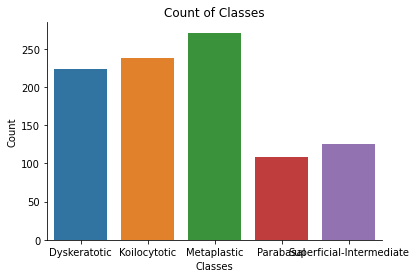

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


plt.title('Count of Classes', size=12)
sns.countplot(cervical_cancer_df.Classification)
plt.ylabel('Count', size=10)
plt.xlabel('Classes', size=10)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
#csv = '/content/cervical_cancer.csv'
y_label = pd.DataFrame(cervical_cancer_df[['Classification_ID']])

train, test = train_test_split(cervical_cancer_df, train_size = 0.8, random_state = 0, shuffle = True, stratify = y_label)

y_label = pd.DataFrame(train[['Classification_ID']])
train, val = train_test_split(train, train_size = 0.87, random_state = 0, shuffle = True, stratify = y_label)
#print(len(train))
#print(len(test))
#print(len(val))

train.to_csv(r'train_csv.csv', index=False)
val.to_csv(r'val_csv.csv', index=False)
test.to_csv(r'test_csv.csv', index=False)


csv = pd.read_csv('train_csv.csv')
#csv.head()

csv.Classification_ID.count()

671

Create train, test, validation datasets

In [ ]:
import torchvision.transforms as transforms
import torch.nn as nn
root_dir = ''
train = '/content/train_csv.csv'
test = '/content/test_csv.csv'
val = '/content/val_csv.csv'

train_dataset = CustomDataset(train, root_dir, transforms.ToTensor())
test_dataset = CustomDataset(test, root_dir, transforms.ToTensor())
val_dataset = CustomDataset(val, root_dir, transforms.ToTensor())

print(f"There are {len(train_dataset)} samples in the dataset.")
print(f"There are {len(test_dataset)} samples in the dataset.")
print(f"There are {len(val_dataset)} samples in the dataset.")


img, label = train_dataset[0]
print(img.size())


There are 671 samples in the dataset.
There are 194 samples in the dataset.
There are 101 samples in the dataset.
torch.Size([3, 258, 258])


# Model and Training

Create Dataloaders

In [ ]:
BATCH_SIZE = 32
EPOCHS = 100
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001

train_dataloader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(dataset = val_dataset, batch_size = BATCH_SIZE, shuffle = True)

Pre-trained Resnet50

In [ ]:
from torchsummary import summary
device = ''
from torchvision import models
from torch import nn


if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

print(f"Using device {device}")

model = models.resnet50(pretrained=True)

model = model.to(device)
model.conv1=nn.Conv2d(3, model.conv1.out_channels, 
                      kernel_size=model.conv1.kernel_size[0], 
                      stride=model.conv1.stride[0], 
                      padding=model.conv1.padding[0])
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(*[nn.Dropout(p=0.25), nn.Linear(num_ftrs, 5)])

Using device cuda


In [ ]:
def train_single_epoch(model, data_loader, loss_fn, optimiser, device):
    for input, target in data_loader:
        input, target = input.to(device), target.to(device)
        # calculate loss
        prediction = model(input)
        loss = loss_fn(prediction, target)
        # backpropagate error and update weights
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    print(f"loss: {loss.item()}")
    #print(optimiser.state_dict()['param_groups'][0]['lr'])


def test_single_epoch(model, dataloader, loss_fn, optimiser, device):
  correct = 0
  size = len(dataloader.dataset)

  with torch.no_grad():
    for input, target in dataloader:
          input, target = input.to(device), target.to(device)
          # calculate loss
          prediction = model(input)
          loss = loss_fn(prediction, target)
          correct += (prediction.argmax(1) == target).type(torch.float).sum().item()
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}% \n")
    return loss.item()

def train_val(model, train_dataloader, test_dataloader, loss_fn, optimiser, device, epochs):
  model.train()
  for i in range(epochs):
      print(f"Epoch {i+1}")
      train_single_epoch(model, train_dataloader, loss_fn, optimiser, device)
      val_loss = test_single_epoch(model, test_dataloader, loss_fn, optimiser, device)
      scheduler.step(val_loss)
      print("---------------------------")
  print("Finished training")





In [ ]:
def test_model(model, dataloader, loss_fn, optimiser, device):
  correct = 0
  size = len(dataloader.dataset)

  model.eval()
  for input, target in dataloader:
        input, target = input.to(device), target.to(device)
        # calculate loss
        prediction = model(input)
        correct += (prediction.argmax(1) == target).type(torch.float).sum().item()
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}% \n")


train, test, trials and errors

In [ ]:
model = model.to(device)
optimiser = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min')

takes about 13 mins on cuda for 5 epochs, 25 mins on cpu for 1 epoch. :)

In [ ]:
optimiser = torch.optim.Adam(model.parameters(),
                              lr=0.0001)
train_val(model, train_dataloader, val_dataloader, criterion, optimiser, device, 50)

Epoch 1
loss: 0.7159364223480225
Test Error: 
 Accuracy: 81.2% 

---------------------------
Epoch 2
loss: 0.6119287610054016
Test Error: 
 Accuracy: 72.3% 

---------------------------
Epoch 3
loss: 0.2918183207511902
Test Error: 
 Accuracy: 82.2% 

---------------------------
Epoch 4
loss: 0.6359865069389343
Test Error: 
 Accuracy: 80.2% 

---------------------------
Epoch 5
loss: 0.4273220896720886
Test Error: 
 Accuracy: 82.2% 

---------------------------
Epoch 6
loss: 0.42035314440727234
Test Error: 
 Accuracy: 85.1% 

---------------------------
Epoch 7
loss: 0.22864043712615967
Test Error: 
 Accuracy: 85.1% 

---------------------------
Epoch 8
loss: 0.22698301076889038
Test Error: 
 Accuracy: 84.2% 

---------------------------
Epoch 9
loss: 0.2974766194820404
Test Error: 
 Accuracy: 86.1% 

---------------------------
Epoch 10
loss: 0.1628149449825287
Test Error: 
 Accuracy: 81.2% 

---------------------------
Epoch 11
loss: 0.1957753598690033
Test Error: 
 Accuracy: 82.2% 



In [ ]:
test_model(model, test_dataloader,criterion, optimiser, device)

Test Error: 
 Accuracy: 89.2% 



In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Saved_Models/CervicalCancer_Resnet50_89.pth')

# With scheduler

In [ ]:
train_val(model, train_dataloader, val_dataloader, criterion, optimiser, device, EPOCHS)

Epoch 1
loss: 0.5683290958404541
Test Error: 
 Accuracy: 80.2% 

---------------------------
Epoch 2
loss: 0.22054748237133026
Test Error: 
 Accuracy: 80.2% 

---------------------------
Epoch 3
loss: 0.14082543551921844
Test Error: 
 Accuracy: 83.2% 

---------------------------
Epoch 4
loss: 0.056341081857681274
Test Error: 
 Accuracy: 84.2% 

---------------------------
Epoch 5
loss: 0.026619527488946915
Test Error: 
 Accuracy: 86.1% 

---------------------------
Epoch 6
loss: 0.07177422940731049
Test Error: 
 Accuracy: 85.1% 

---------------------------
Epoch 7
loss: 0.07012965530157089
Test Error: 
 Accuracy: 84.2% 

---------------------------
Epoch 8
loss: 0.022930707782506943
Test Error: 
 Accuracy: 85.1% 

---------------------------
Epoch 9
loss: 0.013254701159894466
Test Error: 
 Accuracy: 90.1% 

---------------------------
Epoch 10
loss: 0.014206954278051853
Test Error: 
 Accuracy: 88.1% 

---------------------------
Epoch 11
loss: 0.08702082931995392
Test Error: 
 Accura

In [ ]:
test_model(model, test_dataloader,criterion, optimiser, device)

Test Error: 
 Accuracy: 92.3% 

